In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import pickle

# Import the data

The data is imported from the matches.csv file.

In [2]:
matches = pd.read_csv("matches.csv", index_col = 0)
matches

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,NaN,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,NaN,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,NaN,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,NaN,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,NaN,Racing,Barcelona,0:2
...,...,...,...,...,...,...,...,...
49015,2021-2022,2,42,5/29/22,NaN,Real Oviedo,UD Ibiza,NaN
49016,2021-2022,2,42,5/29/22,NaN,Real Sociedad B,Real Zaragoza,NaN
49017,2021-2022,2,42,5/29/22,NaN,Sporting Gijón,UD Las Palmas,NaN
49018,2021-2022,2,42,5/29/22,NaN,CD Tenerife,FC Cartagena,NaN


### Filter only played matches and re-structure the data frame

The data frame contains matches that were never played. We will create a copy of the data frame excluding this cases. We will also create three new columns for our convenience: A home goals column, an away goal columns and a result columns, the latter taking three different values: 1 if home team won, 2 if away team won and X if the result was a tie. 

In [3]:
# We take a copy of the sub data-frame with the valid matches
matches_played = matches.loc[matches.score.notnull()].copy() 

# We create a new data-frame with home and away goals and we append it to the existing data frame
matches_played[['home_goals', 'away_goals']] = matches_played.score.str.split(":", n = 1, expand = True).apply(pd.to_numeric)

# Create results column
matches_played['result'] = 0
matches_played.loc[matches_played.home_goals > matches_played.away_goals, 'result'] = "1"
matches_played.loc[matches_played.home_goals < matches_played.away_goals, 'result'] = "2"
matches_played.loc[matches_played.home_goals == matches_played.away_goals, 'result'] = "X"

matches_played.head()

,season,division,matchday,date,time,home_team,away_team,score,home_goals,away_goals,result
0,1928-1929,1,1,2/10/29,NaN,Arenas Club,Athletic Madrid,2:3,2,3,2
1,1928-1929,1,1,2/10/29,NaN,Espanyol,Real Unión,3:2,3,2,1
2,1928-1929,1,1,2/10/29,NaN,Real Madrid,Catalunya,5:0,5,0,1
3,1928-1929,1,1,2/10/29,NaN,Donostia,Athletic,1:1,1,1,X
4,1928-1929,1,1,2/12/29,NaN,Racing,Barcelona,0:2,0,2,2


In [4]:
matches_played.to_csv("../quiniela/matches_played.csv")

# La Liga Questions

Now we will proceed to answer all questions concerning La Liga Data Analysis.

# Question 1)

We just have to compute the length of the sub-data frames that fulfill the three following conditions (respectively): Home team won, away team won, tie.

In [5]:
# Count wins with len() function
home_wins = len(matches_played[matches_played.result == "1"])
away_wins = len(matches_played[matches_played.result == "2"])
ties = len(matches_played[matches_played.result == "X"])

In [6]:
# A useful function that plots a pie chart to avoid repeating code all along the notebook.
def plot_pie(labels, sizes, title, plot_now, width = 10, height = 4, tsize = 15):
    fig, ax = plt.subplots()
    fig.set_figwidth(width)
    fig.set_figheight(height)

    ax.pie(sizes, explode = [0] * len(labels), labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90)
    ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, size = tsize)

    if plot_now:
        plt.show()
    else:
        plt.close()
    return fig

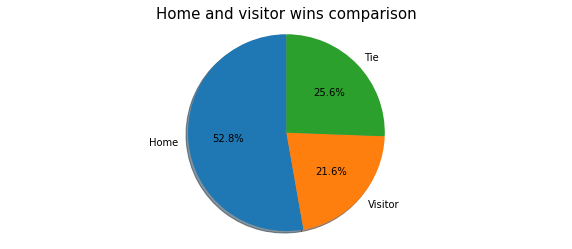

In [7]:
# Pie
labels = ['Home', 'Visitor', 'Tie']
sizes = [home_wins, away_wins, ties]

plot_pie(labels, sizes, "Home and visitor wins comparison", False)

# Question 2)

First, we create an empty dataframe with the categories we want for every team.

In [8]:
# Maybe a team has never played as home team or viceversa, so we merge both sets to assure we get all the team names
home_teams = set(dict.fromkeys(matches_played.loc[:, 'home_team']))
away_teams = set(dict.fromkeys(matches_played.loc[:, 'away_team']))
team_names = list(home_teams | away_teams)
categories = ['wins 1D', 'defeats 1D', 'scored_goals 1D', 'received_goals 1D',
              'wins 2D', 'defeats 2D', 'scored_goals 2D', 'received_goals 2D']

# Empty DF teams
teams = pd.DataFrame(0, columns = categories, index = team_names)

And then we fill the information about the teams applying the following function to all the data frame.

In [9]:
def replenish_statistics(team):
    div1 = matches_played.division == 1

    is_home = matches_played.home_team == team.name
    is_away = matches_played.away_team == team.name

    team_won = (is_home & home_won) | (is_away & away_won)
    team_lost = (is_home & away_won) | (is_away & home_won)

    # Consider changing brackets to .loc brackets
    team['wins 1D'] = len(matches_played[div1 & team_won])
    team['wins 2D'] = len(matches_played[~div1 & team_won])
    team['defeats 1D'] = len(matches_played[div1 & team_lost])
    team['defeats 2D'] = len(matches_played[~div1 & team_lost])

    team['scored_goals 1D'] = np.sum(matches_played.loc[div1 & is_home, 'home_goals']) + np.sum(matches_played.loc[div1 & is_away, 'away_goals'])
    team['scored_goals 2D'] = np.sum(matches_played.loc[~div1 & is_home, 'home_goals']) + np.sum(matches_played.loc[~div1 & is_away, 'away_goals'])
    team['received_goals 1D'] = np.sum(matches_played.loc[div1 & is_home, 'away_goals']) + np.sum(matches_played.loc[div1 & is_away, 'home_goals'])
    team['received_goals 2D'] = np.sum(matches_played.loc[~div1 & is_home, 'away_goals']) + np.sum(matches_played.loc[~div1 & is_away, 'home_goals'])
    return team

In [10]:
# Fill the data frame
home_won = matches_played.result == "1"
away_won = matches_played.result == "2"
teams = teams.apply(replenish_statistics, axis = 1)

### Top 10 scoring teams in 1D

Now we sort the new data frame by scored goals and select the first ten. Those will be top 10 scoring teams of the first division.

In [11]:
# A useful function that plots a bar chart to avoid repeating code all along the notebook.
def plot_bar(x, y, title, ylabel, plot_now, width = 8, height = 5, tsize = 20, fsize = 15, lsize = 18, rot = 50, hor = False):
    if hor:
        plt.barh(x, y)
    else:
        plt.bar(x, y)
    fig = plt.gcf()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax = plt.gca()
    ax.set_title(title, size = tsize)
    if hor:
        ax.set_xlabel(ylabel, fontsize = fsize)
    else:
        ax.set_ylabel(ylabel, fontsize = fsize)
    ax.tick_params(labelsize = lsize)
    plt.setp(ax.get_xticklabels(), horizontalalignment = "right")
    plt.xticks(rotation = rot)
    if plot_now:
        plt.show()
    else:  
        plt.close()
    return fig

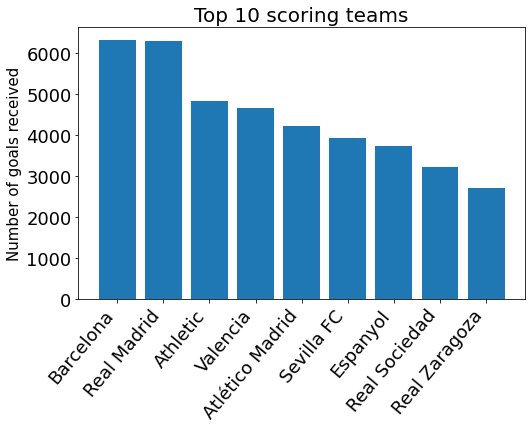

In [12]:
# We sort the teams by scored goals
top_scoring = teams.sort_values('scored_goals 1D', ascending = False)
top_scoring_names = list(top_scoring.index.values[0:9])
top_scoring_ngoals = list(top_scoring.loc[:, 'scored_goals 1D'][0:9])

# And we plot the top 10
plot_bar(top_scoring_names, top_scoring_ngoals, "Top 10 scoring teams", "Number of goals received", False)

### Top 10 scored teams in 1D

Now we do more or less the opposite: We sort the data frame by received goals and select the first ten. Thosw will be the top 10 scored teams in first division.

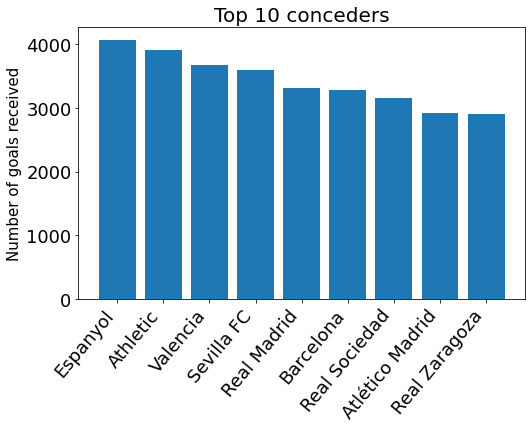

In [13]:
# We sort the teams by received goals
top_scored = teams.sort_values('received_goals 1D', ascending = False)
top_scored_names = list(top_scored.index.values[0:9])
top_scored_ngoals = list(top_scored.loc[:, 'received_goals 1D'][0:9])

# And we plot the top 10
plot_bar(top_scored_names, top_scored_ngoals, "Top 10 conceders", "Number of goals received", False)

### Biggest wins

To see which are the matches with the biggest score difference, we just create another column that is the absolute value of home_goals - away_goals

In [14]:
# Create another column (goal_diff) and sort it in descending order
matches_played.loc[:, 'goal_diff'] = np.abs(matches_played.home_goals - matches_played.away_goals)
matches_played.sort_values('goal_diff', ascending = False).head()

,season,division,matchday,date,time,home_team,away_team,score,home_goals,away_goals,result,goal_diff
26235,1940-1941,2,15,1/8/41,NaN,Real Sociedad,Real Valladolid,14:2,14,2,1,12
225,1930-1931,1,10,2/8/31,NaN,Athletic,Barcelona,12:1,12,1,1,11
27773,1956-1957,2,18,1/13/57,NaN,Real Gijón,Lérida,11:0,11,0,1,11
1168,1941-1942,1,15,1/11/42,NaN,Athletic,Celta de Vigo,10:0,10,0,1,10
27124,1949-1950,2,1,9/4/49,NaN,CE Sabadell,SD Erandio Club,11:1,11,1,1,10


In [15]:
# And now remove now useless goal_diff column
matches_played = matches_played.drop(columns = 'goal_diff')

# Question 3)
### Distribution of matches along weekdays

With the help of the follwing functions, we can get the weekdays of the given dates and, from a column full of weekdays (a number from 0 to 6) we can get a distribution of how many matches were played in each of them.

In [16]:
import calendar

In [17]:
# Given a date, returns the weekday
def get_weekday(date_string):
    # Returns the weekday as an integer from 0 to 6
    month, day, year = date_string.split("/")
    
    if int(year) > 21:
        year = f"19{year}"
    else:
        year = f"20{year}"
        
    return calendar.weekday(int(year), int(month), int(day))

In [18]:
# Given an array of weekdays (number between 0 and 6) returns the distribution
def get_weekday_dist(weekdays):
    distribution = np.zeros(7)
    for weekday in range(0, 7):
        distribution[weekday] = np.sum(weekdays == weekday)
    return distribution

In [19]:
# We map the function get_weekday to the date column
season_weekdays = matches_played.loc[:, ['season', 'date']]
season_weekdays.loc[:, 'date'] = season_weekdays.loc[:, 'date'].apply(get_weekday)

# And we get the desired distributions
weekday_matches = get_weekday_dist(season_weekdays.loc[:, 'date'])
weekday_matches_00_01 = get_weekday_dist(season_weekdays.loc[season_weekdays.season == '2000-2001', 'date'])
weekday_matches_20_21 = get_weekday_dist(season_weekdays.loc[season_weekdays.season == '2020-2021', 'date'])

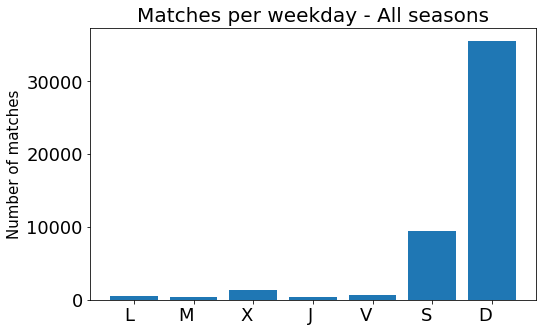

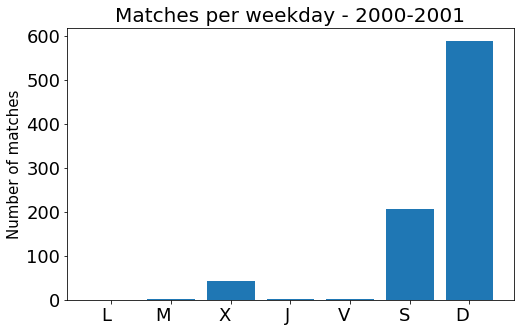

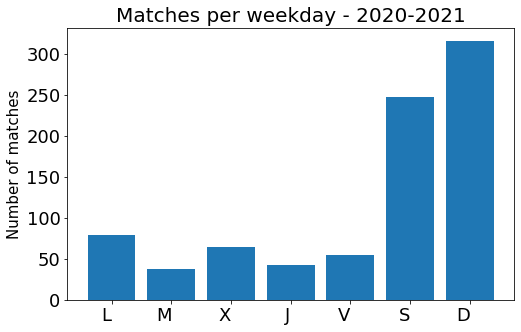

In [20]:
# Then, we plot the results
week_names = ['L', 'M', 'X', 'J', 'V', 'S', 'D']

# We use the function defined earlier
plot_bar(week_names, weekday_matches, "Matches per weekday - All seasons", "Number of matches", True, rot = 0)
plot_bar(week_names, weekday_matches_00_01, "Matches per weekday - 2000-2001", "Number of matches", True, rot = 0)
plot_bar(week_names, weekday_matches_20_21, "Matches per weekday - 2020-2021", "Number of matches", False, rot = 0)

### Distribution of matches along time

We can now do more or less the same but for each time of the day: A distribution of the played matches along time.

In [21]:
# First let's create a function that maps a HHMM|A/PM time format into a number to be able to sort the time properly
def time_mapping(time_format):
    time, midday = time_format.split(" ")
    hours, mins = time.split(":")
    return 60 * int(hours) + int(mins) + (12 * 60 if (midday == "PM") else 0)

In [22]:
# And create a plot_hist function to avoid repeating code
def plot_hist(data, title, ylabel, plot_now, width = 10, height = 4, tsize = 20, fsize = 18, lsize = 10, rot = 80):
    plt.hist(data)
    fig = plt.gcf()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax = plt.gca()
    ax.set_title(title,size = tsize)
    ax.set_ylabel(ylabel, fontsize = fsize)
    ax.tick_params(labelsize = lsize)
    plt.xticks(rotation = rot)
    if plot_now:
        plt.show()
    else:
        plt.close()
    return fig

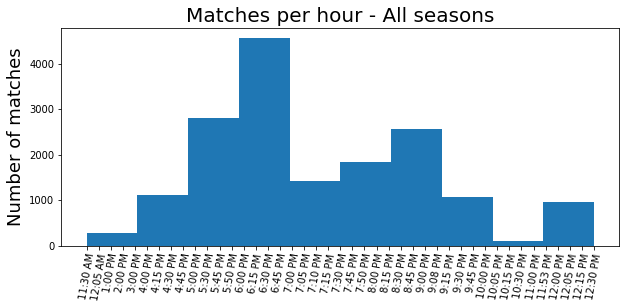

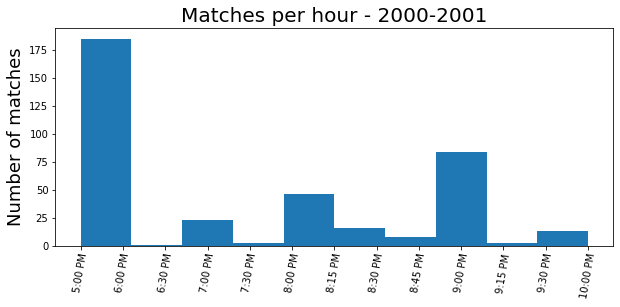

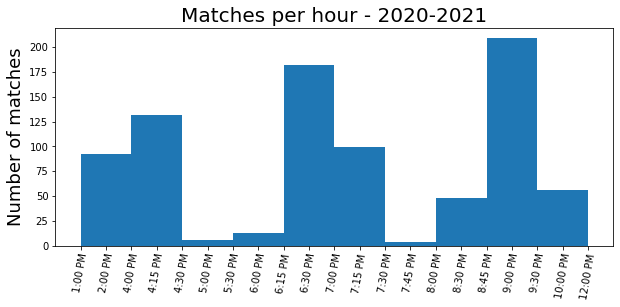

In [23]:
# We retrieve the sorted times filtering the null values
filtered_times = matches_played.loc[matches_played.time.notnull()].sort_values('time', ascending = False)
filtered_times.loc[:, 'mapped_time'] = filtered_times.loc[:, 'time'].apply(time_mapping)
filtered_times = filtered_times.sort_values('mapped_time')

# And we plot a histogram
plot_hist(filtered_times.loc[:, 'time'], "Matches per hour - All seasons", "Number of matches", True)
plot_hist(filtered_times.loc[filtered_times.season == '2000-2001', 'time'], "Matches per hour - 2000-2001", "Number of matches", True)
plot_hist(filtered_times.loc[filtered_times.season == '2020-2021', 'time'], "Matches per hour - 2020-2021", "Number of matches", False)

# Question 4)

We will now plot a table representing all the matches between different teams for a unique season (2020-2021) and division.

In [24]:
# Let's select only 1D matches in 2020-2021 season and create a table with the results
matches_1d_20_21 = matches_played.loc[(matches_played.division == 1) & (matches_played.season == '2020-2021')].copy()
df_table = pd.crosstab(matches_1d_20_21.home_team, matches_1d_20_21.away_team,
                       values = matches_1d_20_21.score, aggfunc = lambda x: ' '.join(x)).fillna('-')

In [25]:
# Let's write two functions to apply to all the table to get our difference matrices
def get_difference(score):
    if score == "-":
        return 0 
    home_goals, away_goals = score.split(":")
    return int(home_goals) - int(away_goals)

def to_df_get_difference(serie):
    return serie.apply(get_difference)

# And a function to obtain an abbreviation given a name
def abbreviation(s):
    return s[0:3]

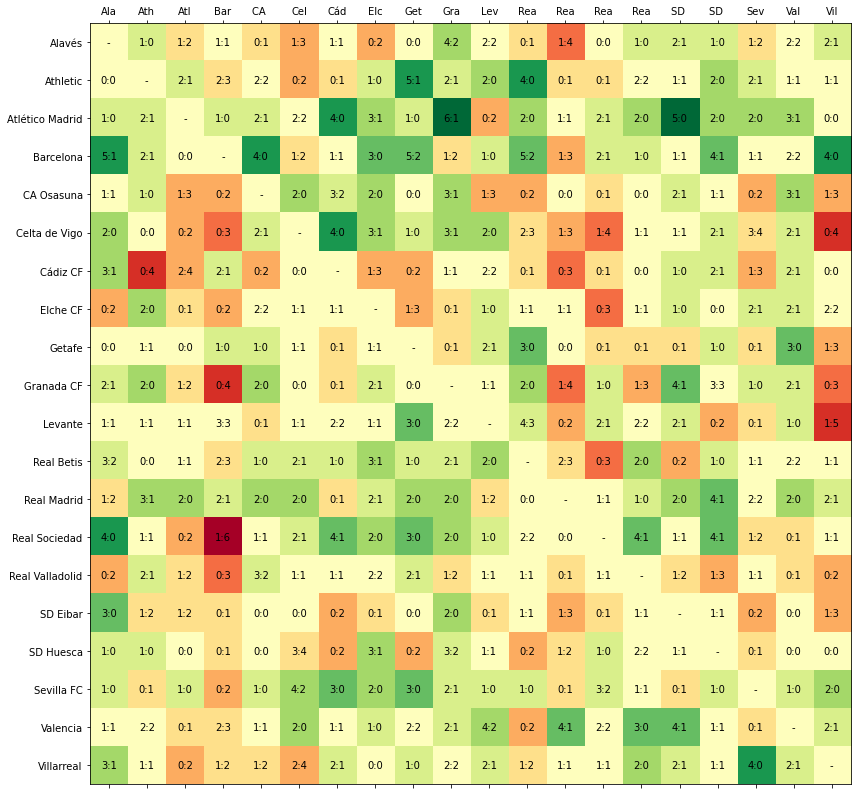

In [26]:
# The home and away teams sorted
sorted_home = sorted(list(dict.fromkeys(matches_1d_20_21.loc[:, 'home_team'])), key = str.lower)
sorted_away = sorted(list(dict.fromkeys(matches_1d_20_21.loc[:, 'away_team'])), key = str.lower)

# We get the difference matrix applied to all the data frame
diff_matrix = df_table.apply(to_df_get_difference)

# We create the matshow plot
fig = plt.figure(figsize = (80, 14))
ax = fig.add_subplot(111)
ax.matshow(diff_matrix, cmap = plt.cm.RdYlGn)

# And we add the results
for j, away in enumerate(sorted_away):
    for i, home in enumerate(sorted_home):
        ax.text(i, j, df_table[home][away], va='center', ha='center')
    sorted_away[j] = abbreviation(away)

ax.set_xticks(np.arange(len(sorted_away)))
ax.set_yticks(np.arange(len(sorted_home)))
a = ax.set_xticklabels(sorted_away)
a = ax.set_yticklabels(sorted_home)
plt.show()

# Question 5)

To plot direct confrontation between teams, we first create a sub-data frame containing only the matches these 2 teams played. Then we filter the concrete cases where one or another won, and the number of goals scored.

In [27]:
# The following two functions are only used in the third in an effort to make the code a little bit cleaner
def get_wins_goals_stats(team1, team2):
    # Two useful dictionaries
    wins = {team1: 0, 'Ties': 0, team2: 0}
    goals = {team1: 0, team2: 0}

    # Let's isolate the cases were both teams played
    both_played = ((matches_played.home_team == team1) & (matches_played.away_team == team2)) | ((matches_played.home_team == team2) & (matches_played.away_team == team1))
    both_teams = matches_played.loc[both_played]

    # Now let's take the cases were the home team won and were both teams got a tie
    home_won = both_teams.home_goals > both_teams.away_goals
    tie = both_teams.home_goals == both_teams.away_goals

    t1_is_home = both_teams.home_team == team1

    #From these booleans we can get how many matches each team won
    team1_won = (t1_is_home & home_won) | (~t1_is_home & ~home_won & ~tie)
    team2_won = ~team1_won & ~tie

    wins[team1] = np.sum(team1_won)
    wins[team2] = np.sum(team2_won)
    wins['Ties'] = np.sum(tie)

    goals[team1] = np.sum(both_teams.loc[t1_is_home, 'home_goals']) + np.sum(both_teams.loc[~t1_is_home, 'away_goals'])
    goals[team2] = np.sum(both_teams.loc[~t1_is_home, 'home_goals']) + np.sum(both_teams.loc[t1_is_home, 'away_goals'])
    return wins, goals

def plot_wins_goals_stats(wins, goals, team1, team2):

    # We use the function we defined at the top of the notebook
    labels1 = [team1, 'Tie', team2]
    sizes1 = list(wins.values())
    labels2 = [team1, team2]
    sizes2 =list(goals.values())
    return plot_pie(labels1, sizes1, f"Wins between {team1} and {team2} teams", True), plot_pie(labels2, sizes2, f"Goals between {team1} and {team2} teams", True)    

def plot_direct_confrontations_stats(team1, team2):

    # Security checks
    if team1 == team2:
        print("Please enter 2 different teams.")
        return 
    
    if (team1 not in team_names) or (team2 not in team_names):
        print("At least one of those teams doesn't exist.")
        return
    
    wins, goals = get_wins_goals_stats(team1, team2)
    return plot_wins_goals_stats(wins, goals, team1, team2)

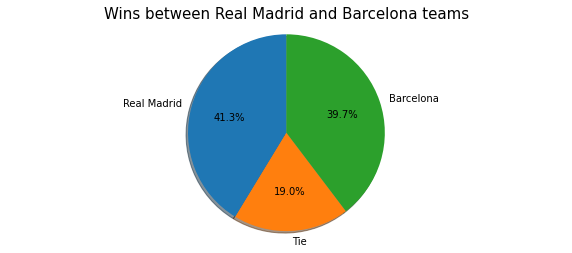

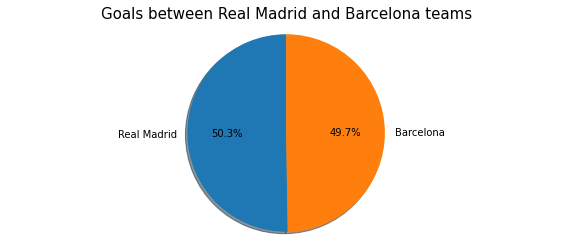

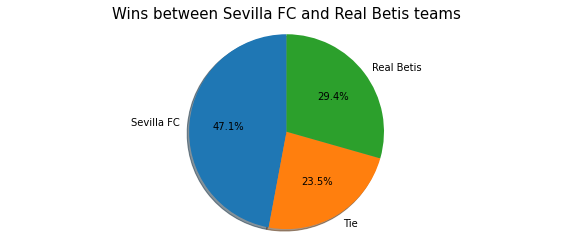

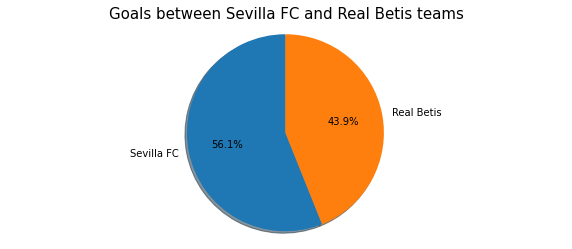

In [28]:
wins_RM_BAR, goals_RM_BAR = plot_direct_confrontations_stats("Real Madrid", "Barcelona")
wins_SEV_BET, goals_SEV_BET = plot_direct_confrontations_stats("Sevilla FC", "Real Betis")

# Question 6)

We will now plot the longest streaks each time had. We first create a data frame of streaks with a length equal to the number of teams and define a function that fills the information for every row, applied to all the data frame. For our convenience, this new data frame will contain a row of lengths of the streaks and a second row containing a string of the form: {team}: {start_date} - {end-date}.

In [29]:
def evaluate_streaks(team):
    # We filter matches that were only played by the team
    team_matches = matches_played.loc[(matches_played.home_team == team.name) | (matches_played.away_team == team.name)]
    
    # We get a boolean array being true if the team won or the result was a tie and false otherwise
    is_home = team_matches.home_team == team.name
    team_won = (is_home & (team_matches.home_goals >= team_matches.away_goals)) | (~is_home & (team_matches.away_goals >= team_matches.home_goals))
    
    # With the function np.where() we get useful information about where the consecutive Trues and Falses are
    split_indexes = np.where(team_won == False)[0]
    
    # We compute the difference (length of each streak) and sort accordingly.
    diff_split = np.diff(split_indexes) - 1
    sorted_indexes = [length for _, length in sorted(zip(diff_split, split_indexes), reverse = True)]

    longest_streak_len = np.max(diff_split) if (len(diff_split) > 0) else 0
    team['length'] = longest_streak_len
    
    # From the indexes of the streaks we can also get the start and end dates.
    if (longest_streak_len > 0):
        start_index = sorted_indexes[0]
        end_index = sorted_indexes[0] + longest_streak_len
        
        team['start-end'] = f"{team.name}: {team_matches.iloc[start_index]['date']} - {team_matches.iloc[end_index]['date']}"
    return team

In [30]:
#Let's create an empty data frame and fill it with the streaks
columns_streaks = ['length', 'start-end']
streaks = pd.DataFrame(0, index = team_names, columns = columns_streaks).apply(evaluate_streaks, axis = 1)

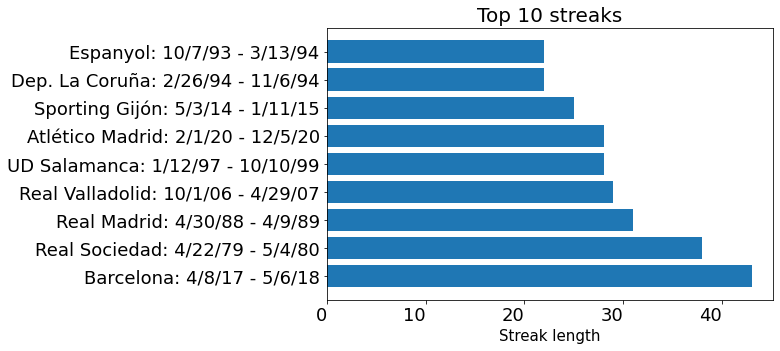

In [31]:
# Let's sort, get the top 10 streaks and make the bar plot
top_10_streaks = streaks.sort_values('length', ascending = False).iloc[0:9]
plot_bar(top_10_streaks.loc[:, 'start-end'], top_10_streaks.loc[:, 'length'], "Top 10 streaks", "Streak length", False, hor = True, rot = 0)

# Question 7)

To create the standings, we cannot pre-create an empty data frame for it as we don't know how many teams played for every season, so we will have to iterate over every season and create there a data frame with length equal to the number of teams that played. We then fill the standings for that season sorted accordingly and save it in a list of data frames. At the end, we concatenate them all to have our final standings data frame.

In [32]:
# Let's create a useful function to fill a concrete season standing row
def fill_season_standing_row(statistic):
    is_home = in_standing.home_team == statistic['team']
    is_away = in_standing.away_team == statistic['team']
    
    # Filter each case
    team_won = (is_home & home_won) | (is_away & away_won)
    team_lost = (is_home & away_won) | (is_away & home_won)
    team_tie = (is_home | is_away) & tie
    div = in_standing.loc[is_home | is_away, 'division']

    statistic['pts'] = 3 * np.sum(team_won) + np.sum(team_tie)
    statistic['division'] = div.iloc[0]
    statistic['GF'] = np.sum(in_standing.loc[is_home, 'home_goals']) + np.sum(in_standing.loc[is_away, 'away_goals'])
    statistic['GA'] = np.sum(in_standing.loc[is_home, 'away_goals']) + np.sum(in_standing.loc[is_away, 'home_goals'])
    statistic['GD'] = statistic['GF'] - statistic['GA']
    statistic['W'] = np.sum(team_won)
    statistic['L'] = np.sum(team_lost)
    statistic['T'] = np.sum(team_tie)
    return statistic

In [33]:
# The seasons and categories of the standings data frame
seasons = list(dict.fromkeys(matches_played['season']))
seasons.reverse()
categories = ['season', 'division', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'pts']

# We will create as many data frames as there are seasons, sort them individually and then merge them
season_standings = [None] * len(seasons)
for i, season in enumerate(seasons):
    in_standing = matches_played.loc[matches_played.season == season]
    home_teams = set(dict.fromkeys(in_standing.loc[:, 'home_team']))
    away_teams = set(dict.fromkeys(in_standing.loc[:, 'away_team']))
    teams = list(home_teams | away_teams)
    season_standing = pd.DataFrame(np.zeros([len(teams), len(categories)], dtype = int), columns = categories)

    season_standing.loc[:, 'season'] = season
    season_standing.loc[:, 'team'] = teams

    home_won = in_standing.home_goals > in_standing.away_goals
    away_won = in_standing.home_goals < in_standing.away_goals
    tie = in_standing.home_goals == in_standing.away_goals

    # May be a good idea to reset the index
    season_standing = season_standing.apply(fill_season_standing_row, axis = 1).sort_values(['division', 'pts', 'GD', 'GF'], ascending = [True, False, False, False])
    season_standing.loc[:, 'rank'] = range(1, len(season_standing) + 1)
    season_standings[i] = season_standing

#pd.set_option("display.max_rows", None, "display.max_columns", None)
seasons = sorted(list(dict.fromkeys(matches_played['season'])), key = str.lower, reverse = True)
stand_dict = dict(zip(seasons, season_standings))

season_standings = pd.concat(season_standings)
# Let's import the standings to the reports folder
season_standings.to_excel("../reports/SeasonStandings.xlsx")

In [34]:
with open("../quiniela/stand_dict.p" , "wb") as write:
    pickle.dump( stand_dict , write )

# Question 8)

To plot the ranking evolution of a given team, we will make use of the standings data frame. Befor the plot we will have to re-sort it so older seasons come first.

In [35]:
# Useful function of a simple line plot
def set_fig_plot_line(title, xlabel, ylabel, plot_now, width = 22, height = 5, tsize = 20, xfsize = 15, yfsize = 15, lsize = 10, rot = 50):
    fig = plt.gcf()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax = plt.gca()
    ax.set_title(title, size = tsize)
    ax.set_ylabel(ylabel, fontsize = yfsize)
    ax.set_xlabel(xlabel, fontsize = xfsize)
    ax.tick_params(labelsize = lsize)
    plt.gca().invert_yaxis()
    plt.xticks(rotation = rot)
    plt.legend()
    if plot_now:
        plt.show()
    else:
        plt.close()
    return fig

In [36]:
def plot_ranking_evolution(*args):

    # We need to re-sort the season_standings so older season come first
    ascending_season_standings = season_standings.sort_values(['season', 'division', 'pts', 'GD', 'GF'], ascending = [True, True, False, False, False])
    for team in args:
        season_rank = ascending_season_standings.loc[ascending_season_standings.team == team, ['season', 'rank']]
        plt.plot(season_rank['season'], season_rank['rank'], label = team)
    
    # The plot
    return set_fig_plot_line("Rank evolution over seasons", "Season", "Team ranks", True)

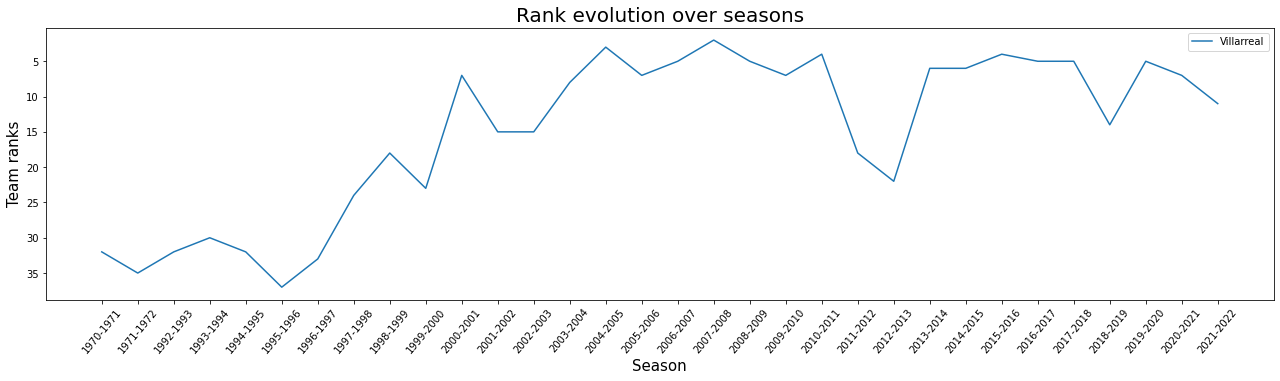

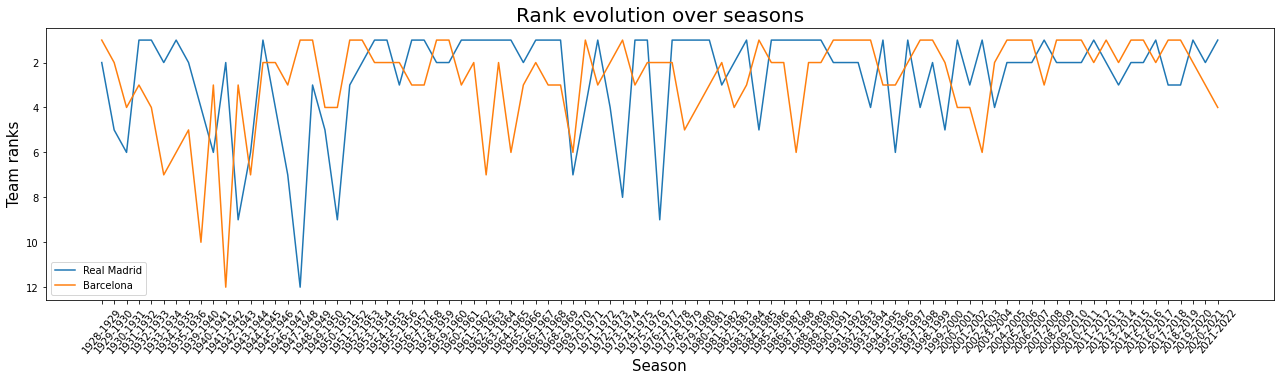

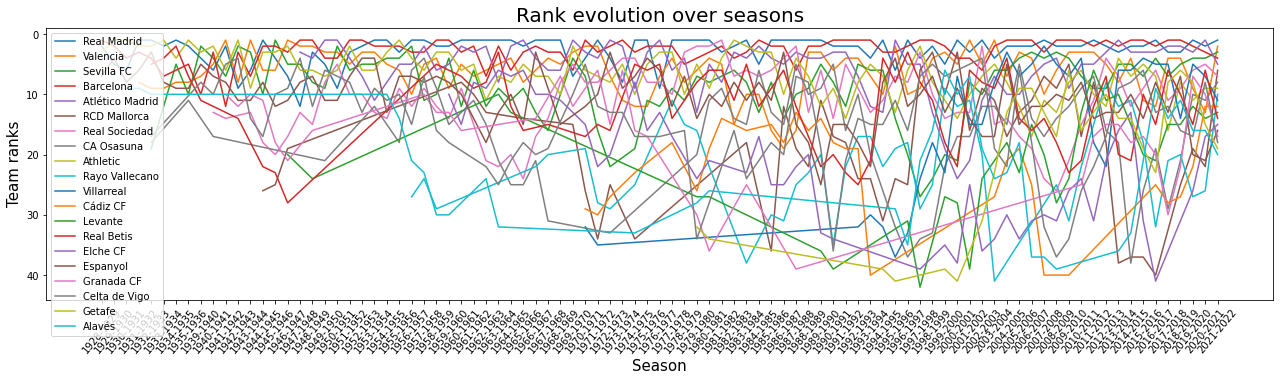

In [37]:
# Now we can make use of the function
plot_ranking_evolution("Villarreal")
plot_ranking_evolution("Real Madrid", "Barcelona")
teams_1D = tuple(dict.fromkeys(season_standings.loc[(season_standings.division == 1) & (season_standings.season == '2021-2022'), 'team']))
fig = plot_ranking_evolution(*teams_1D)

# Question 9)

This task is pretty straightforward. We can measure how much of an elevator team a team is by summng the absolute value of the diff array with np.diff. We then create a function to plot this fluctuation between seasons.

In [38]:
# We create an "elevator meter" that, for each team, is the sum of the division difference.
elevator_meter = [0] * len(team_names)

for i, team in enumerate(team_names):
    divs = season_standings.loc[season_standings.team == team, 'division']
    elevator_meter[i] = np.sum(np.abs(np.diff(divs)))

# Then we just convert it to a data frame and sort it in descending order
sorted_teams = pd.DataFrame({'team': [team for _, team in sorted(zip(elevator_meter, team_names), reverse = True)], 'elevator_meter': sorted(elevator_meter, reverse = True)})
sorted_teams

,team,elevator_meter
0,Dep. La Coruña,20
1,Racing,17
2,Celta de Vigo,17
3,Rayo Vallecano,15
4,Real Valladolid,14
...,...,...
147,Alzira,0
148,Alicante CF,0
149,Algeciras CF,0
150,Alcorcón,0


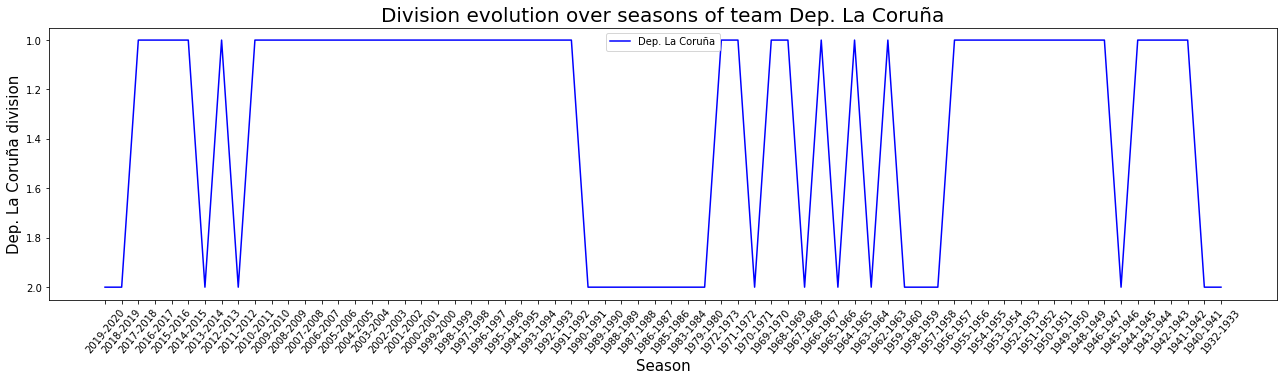

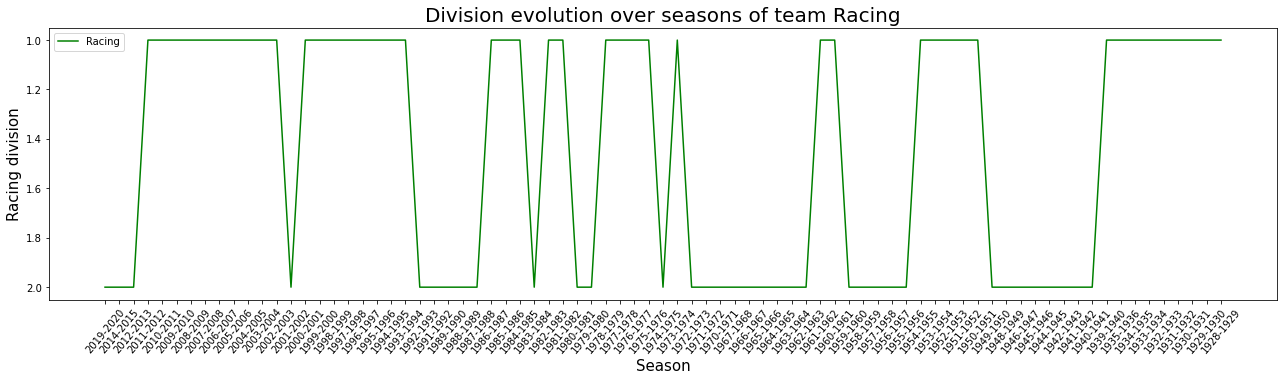

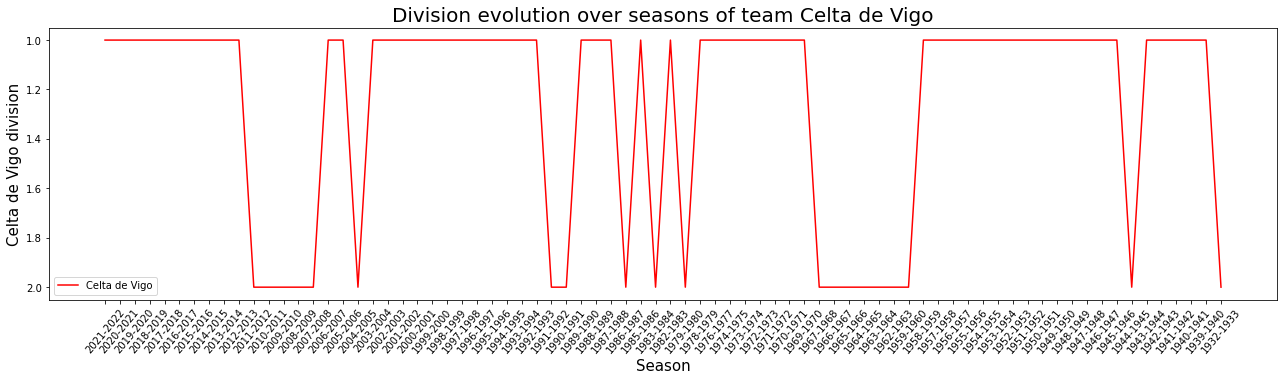

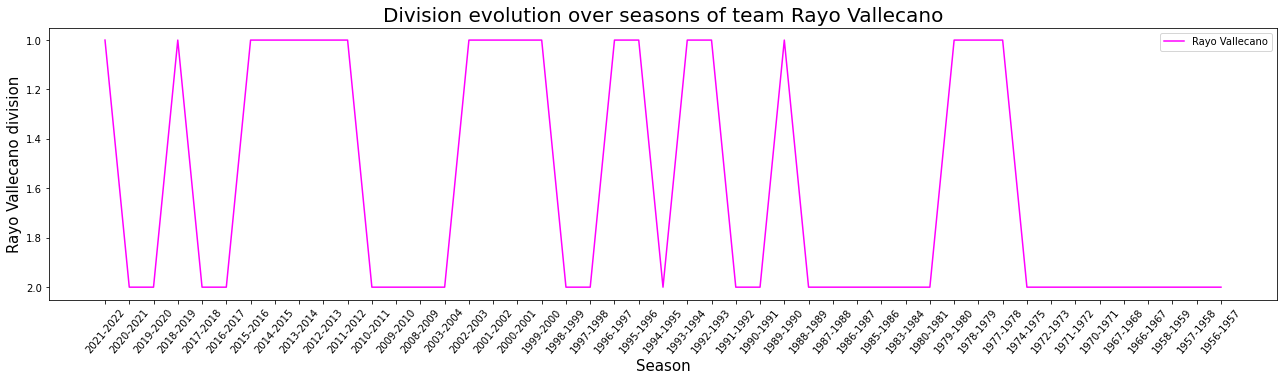

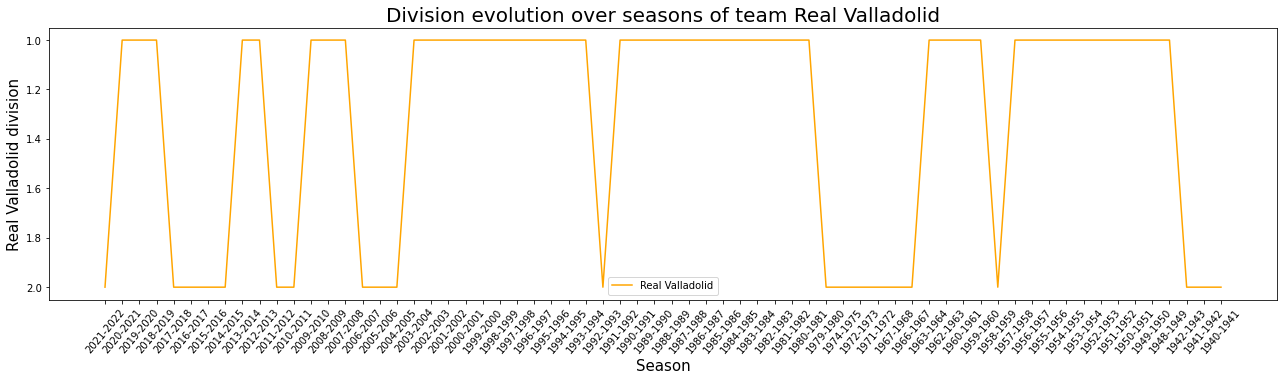

In [39]:
# And now we create a similar function to the previous one to plot the division evolution
def plot_division_evolution(team, color):
    season_divs = season_standings.loc[season_standings.team == team, ['season', 'division']]
    plt.plot(season_divs['season'], season_divs['division'], label = team, color = color)
    set_fig_plot_line(f"Division evolution over seasons of team {team}", "Season", f"{team} division", True)

colors = ["blue", "green", "red", "magenta", "orange"]
for i, color in enumerate(colors):
    plot_division_evolution(sorted_teams.loc[i, 'team'], color)

# Question 10)

This question is similar to exercise 7 but now the standings are created for each matchday of each division of each season. Because of this, the computation takes a long time.

In [40]:
# Let's create a useful function to fill a concrete season standing row
def fill_matchday_standing_row(statistic):
    statistic = fill_season_standing_row(statistic)
    last_5 = []
    for standing in (prev_in_standings_1d if (div == 1) else prev_in_standings_2d):
        is_home = standing.home_team == statistic['team']
        is_away = standing.away_team == statistic['team']
        
        home_won = standing.home_goals > standing.away_goals
        away_won = standing.home_goals < standing.away_goals
        tie = standing.home_goals == standing.away_goals

        team_won = (is_home & home_won) | (is_away & away_won)
        team_lost = (is_home & away_won) | (is_away & home_won)
        team_tie = (is_home | is_away) & tie
        if np.sum(team_won) > 0:
            last_5.append("W")
        elif np.sum(team_lost) > 0:
            last_5.append("L")
        elif np.sum(team_tie) > 0:
            last_5.append("T")
    
    last_5.reverse()
    statistic['last_5'] = last_5
    return statistic

In [41]:
def get_matchday_standing(div):
    global in_standing
    matchday = matchday_1d if (div == 1) else matchday_2d
    in_standing = matches_played.loc[(matches_played.season == season) & (matches_played.matchday == matchday) & (matches_played.division == div)]
    home_teams = set(dict.fromkeys(in_standing.loc[:, 'home_team']))
    away_teams = set(dict.fromkeys(in_standing.loc[:, 'away_team']))
    teams = list(home_teams | away_teams)
    matchday_standing = pd.DataFrame(np.zeros([len(teams), len(categories)], dtype = int), columns = categories)

    matchday_standing.loc[:, 'season'] = season
    matchday_standing.loc[:, 'matchday'] = matchday
    matchday_standing.loc[:, 'division'] = div
    matchday_standing.loc[:, 'team'] = teams
    
    global home_won, away_won, tie
    home_won = in_standing.home_goals > in_standing.away_goals
    away_won = in_standing.home_goals < in_standing.away_goals
    tie = in_standing.home_goals == in_standing.away_goals
    matchday_standing = matchday_standing.apply(fill_matchday_standing_row, axis = 1).sort_values(['division', 'pts', 'GD', 'GF'], ascending = [True, False, False, False])
    matchday_standing.loc[:, 'rank'] = range(1, len(matchday_standing) + 1)
    return matchday_standing

In [42]:
# The procedure is similar to exercise 7
# The dates and categories of the standings data frame
categories = ['season', 'division', 'matchday', 'rank', 'team', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'pts', 'last_5']

pd.set_option("display.max_rows", None, "display.max_columns", None)
matchday_standings = []
for season in seasons:
    prev_in_standings_1d = []
    prev_in_standings_2d = []
    matchdays_1d = list(dict.fromkeys(matches_played.loc[(matches_played.season == season) & (matches_played.division == 1), 'matchday']))
    matchdays_2d = list(dict.fromkeys(matches_played.loc[(matches_played.season == season) & (matches_played.division == 2), 'matchday']))
    print(f"Season: {season}")
    div = 1
    for matchday_1d in matchdays_1d:
        matchday_standing_1d = get_matchday_standing(1)

        matchday_standings.append(matchday_standing_1d)
        prev_in_standings_1d.append(in_standing)
        if len(prev_in_standings_1d) > 5:
            prev_in_standings_1d.pop(0)

    div = 2
    for matchday_2d in matchdays_2d:
        matchday_standing_2d = get_matchday_standing(2)

        matchday_standings.append(matchday_standing_2d)
        prev_in_standings_2d.append(in_standing)
        if len(prev_in_standings_2d) > 5:
            prev_in_standings_2d.pop(0)

pd.set_option("display.max_rows", None, "display.max_columns", None)
matchday_standings = pd.concat(matchday_standings)

Season: 2021-2022
Season: 2020-2021
Season: 2019-2020
Season: 2018-2019
Season: 2017-2018
Season: 2016-2017
Season: 2015-2016
Season: 2014-2015
Season: 2013-2014
Season: 2012-2013
Season: 2011-2012
Season: 2010-2011
Season: 2009-2010
Season: 2008-2009
Season: 2007-2008
Season: 2006-2007
Season: 2005-2006
Season: 2004-2005
Season: 2003-2004
Season: 2002-2003
Season: 2001-2002
Season: 2000-2001
Season: 1999-2000
Season: 1998-1999
Season: 1997-1998
Season: 1996-1997
Season: 1995-1996
Season: 1994-1995
Season: 1993-1994
Season: 1992-1993
Season: 1991-1992
Season: 1990-1991
Season: 1989-1990
Season: 1988-1989
Season: 1987-1988
Season: 1986-1987
Season: 1985-1986
Season: 1984-1985
Season: 1983-1984
Season: 1982-1983
Season: 1981-1982
Season: 1980-1981
Season: 1979-1980
Season: 1978-1979
Season: 1977-1978
Season: 1976-1977
Season: 1975-1976
Season: 1974-1975
Season: 1973-1974
Season: 1972-1973
Season: 1971-1972
Season: 1970-1971
Season: 1969-1970
Season: 1968-1969
Season: 1967-1968
Season: 19

In [43]:
# Let's import the standings to the reports folder
matchday_standings.to_excel("../reports/MatchdayStandings.xlsx")